Pupil Core device timing
========================

`PupilCore().light_stamper(...)` marks the onset of a light stimulus by sending an annotation containing the timestamp of the first frame where the light becomes visible to the
World camera. This timestamp is ultimately what gets used to extract pupil data and as a reference for calculating time-critical measures, such as constriction latency and time-to-peak constriction. The validity of any time-related measures therefore depends on Pupil Capture's ability to synchronise the clocks of the cameras on a Pupil Core headset. How well does it handle this task? When we discovered that the near-infrared from STLABs amber channel gets detected by both Eye and World cameras, we were able to [design a protocol](05e_pupil_core_camera_sync.ipynb) to test this ourselves using the `.light_stamper(...)` method. The protocol basically involved putting the Pupil Core headset inside the integrating sphere and repeatedly flashing a bright orange light in a dark room. Prior to each flash, we instantiate a `.light_stamper(...)` for each of the cameras, which gives us the pupil timestamp from the frame where the light was detected for each camera. This allows us to get some insight into how well the data streams are synchronised. 

We ran the testing protocol on Mac and Windows (Pupil Capture v3.2-20) for *n* = 100 near-IR light flashes. For each run of the protocol, Eye camera resolution was kept at (192, 192) with Absolute Exposure Time of 25, and the World camera had (640, 480) and 60. Auto Exposure Mode was set to 'manual mode' for all cameras, and Auto Exposure Priority was disabled for the World camera. Whilst all of these camera settings may have the potential to impact the precision of the `.light_stamper(...)`, Frame rate is the most obvious. So we performed separate trials on Mac and Windows with a Frame rate of 60 and 120.


In [1]:
import os
import os.path as op
import glob

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.2)

Calculate differences from annotation timestamps
------------------------------------------------

In [2]:
datadir = '../data/pupil_core_camera_sync_tests'
recordings = glob.glob(datadir + '/**/**/**/annotations.csv')

data = pd.DataFrame()
for rec in recordings:
    # Load annotations and get camera timestamps for detected light flash
    df = pd.read_csv(rec)
    eye_0 = df.loc[df.label=='light_on_eye_0', 'timestamp'].to_numpy()
    eye_1 = df.loc[df.label=='light_on_eye_1', 'timestamp'].to_numpy() 
    world = df.loc[df.label=='light_on_world', 'timestamp'].to_numpy()
    
    # Calculate timestamp differences and make DataFrame
    diffs = (pd.DataFrame(data=[(eye_0-world)*1000,
                                (eye_1-world)*1000,
                                (eye_0-eye_1)*1000],
                          index=['eye0 - world',
                                 'eye1 - world',
                                 'eye0 - eye1'])
               .T.melt(var_name='Comparison', 
                       value_name='Timestamp difference (ms)'))
    
    # Add categories for operating system and frames per second
    diffs['OS'] = 'Mac' if 'mac' in rec else 'Windows'
    diffs['FPS'] = '120' if '120_fps' in rec else '60'
    diffs.to_csv(op.join(op.dirname(rec), 'annotation_timestamp_diffs.csv'))
    
    # Append to master frame
    data = data.append(diffs)
data

,Comparison,Timestamp difference (ms),OS,FPS
0,eye0 - world,58.807,Windows,120
1,eye0 - world,55.010,Windows,120
2,eye0 - world,58.925,Windows,120
3,eye0 - world,57.622,Windows,120
4,eye0 - world,58.371,Windows,120
...,...,...,...,...
295,eye0 - eye1,-3.959,Mac,60
296,eye0 - eye1,-3.968,Mac,60
297,eye0 - eye1,12.266,Mac,60
298,eye0 - eye1,-3.984,Mac,60


In [3]:
recordings

['../data/pupil_core_camera_sync_tests/win_camera_sync_120_fps/exports/000/annotations.csv',
 '../data/pupil_core_camera_sync_tests/win_camera_sync_60_fps/exports/000/annotations.csv',
 '../data/pupil_core_camera_sync_tests/mac_camera_sync_120_fps/exports/000/annotations.csv',
 '../data/pupil_core_camera_sync_tests/mac_camera_sync_60_fps/exports/000/annotations.csv']

Plot the timestamp differences
------------------------------

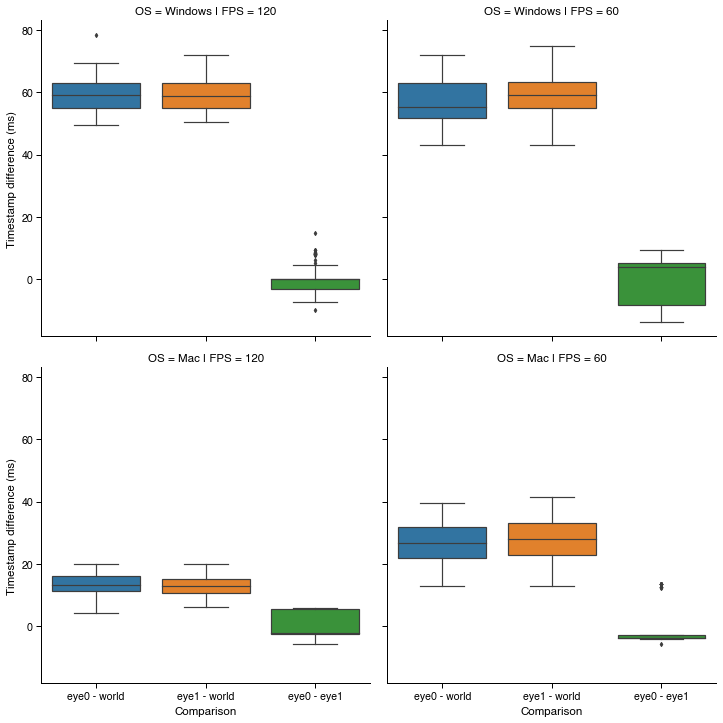

In [4]:
g = sns.catplot(data=data, 
                x='Comparison', 
                y='Timestamp difference (ms)', 
                row='OS', 
                col='FPS',
                kind='box', 
                order=['eye0 - world', 'eye1 - world', 'eye0 - eye1'],
                flierprops={'markersize':3})
#g.savefig('../img/PupilCore_camera_sync.png')

Interpretation
--------------

These data show the time difference between when the same light flash was detected by concurrent `.light_stamper(...)`'s running for both Eye cameras and the World camera. On Mac and Windows, the Eye cameras appear to be well-synchronised with a margin of error that is to be expected given the frame rate. On Windows, the light flashes were consistently stamped on the World camera around 60 ms before they were stamped on the Eye cameras for both 60 and 120 FPS. The same pattern was observed, though to a lesser degree, with Mac. The timestamps were best synchronised on Mac OS with cameras running at 120 FPS, where the World camera lead by 15 ms on average.

Implications
------------

It is difficult to interpret these data without a detailed understanding of the inner workings of the Pupil software. But in practical terms, as far as the PLR is concerned, our data suggest that any time-critical measures using a World camera `.light_stamper(...)` timestamp as a reference point will be consistently *overestimated* by 15 to 60 ms, depending on the operating system and camera settings being used. But, given the high level of repeatability, a reasoanble case can be made for correcting the timestamps using the average difference on an OS-camera-settings basis.

It is worth noting that the 'ground truth' for measures of constriction latency and pupil size is inaccessible, and that values depend strongly on hardware, settings, and measurement principles. Our data show at least that with Pupil Core we can achieve a level of precision that rivals that of automated pupillometers.